In [1]:
import json
import pandas as pd
import os

In [4]:
def update_provincia_ids(json_path, csv_path, output_path):
    """
    Carga el GeoJSON de provincias y el CSV de códigos de provincia,
    y actualiza cada feature['properties']['id'] e 'id' con el código INE.
    """
    # 1) Leer GeoJSON
    with open(json_path, 'r', encoding='utf-8') as f:
        geo = json.load(f)

    # 2) Leer CSV de códigos
    df_codes = pd.read_csv(csv_path, dtype=str, delimiter=";")
    mapping = dict(zip(df_codes['name'], df_codes['cod_prov']))

    # 3) Actualizar cada feature
    missing = []
    for feat in geo.get('features', []):
        prov_name = feat['properties'].get('name')
        cod = mapping.get(prov_name)
        if cod:
            feat['properties']['id'] = cod
            feat['id'] = cod
        else:
            missing.append(prov_name)

    if missing:
        print(f"Advertencia: No se encontró código para: {sorted(set(missing))}")

    # 4) Guardar nuevo GeoJSON
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(geo, f, ensure_ascii=False, indent=2)

In [5]:
if __name__ == "__main__":
    json_input  = "../data/mapas/esp_prov.json"
    csv_input   = "../data/codigos_ine_prov_ccaa/codigos_prov_mapa.csv"
    json_output = "..data/mapas/esp_prov_codigos.json"
    update_provincia_ids(json_input, csv_input, json_output)
    print(f"GeoJSON actualizado guardado en: {json_output}")

GeoJSON actualizado guardado en: ..data/mapas/esp_prov_codigos.json


Ajustamos santa cruz y las palmas para que no queden tan alejadas del mapa

In [6]:
from shapely.geometry import shape, mapping
from shapely.affinity import translate, scale

def adjust_canarias(json_input, json_output, dx=10.0, dy=5.0, scale_factor=0.8):
    """
    Ajusta la posición y escala de las Islas Canarias en un GeoJSON de provincias.
    
    - dx, dy: traslado en grados (longitud, latitud).
    - scale_factor: factor de escala para reducir tamaño.
    """
    # Cargar GeoJSON
    with open(json_input, 'r', encoding='utf-8') as f:
        geo = json.load(f)

    for feat in geo['features']:
        prov_id = feat['properties'].get('id')
        # Provincias canarias: Las Palmas (35) y Santa Cruz de Tenerife (38)
        if prov_id in ('35', '38'):
            geom = shape(feat['geometry'])
            # Escalar centrado
            geom_scaled = scale(geom, xfact=scale_factor, yfact=scale_factor, origin='centroid')
            # Trasladar
            geom_moved = translate(geom_scaled, xoff=dx, yoff=dy)
            feat['geometry'] = mapping(geom_moved)

    # Guardar nuevo GeoJSON
    os.makedirs(os.path.dirname(json_output), exist_ok=True)
    with open(json_output, 'w', encoding='utf-8') as f:
        json.dump(geo, f, ensure_ascii=False, indent=2)

In [29]:
if __name__ == "__main__":
    input_path  = "..data/mapas/esp_prov_codigos.json"
    output_path = "../mapas/esp_prov_canarias_ajustada.json"
    # Ajusta con dx: +12 grados, dy: -8 grados, escala al 70%
    adjust_canarias(input_path, output_path, dx=+3.0, dy=+8.0, scale_factor=0.7)
    print(f"GeoJSON con Canarias ajustadas guardado en: {output_path}")

GeoJSON con Canarias ajustadas guardado en: ../mapas/esp_prov_canarias_ajustada.json


In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt

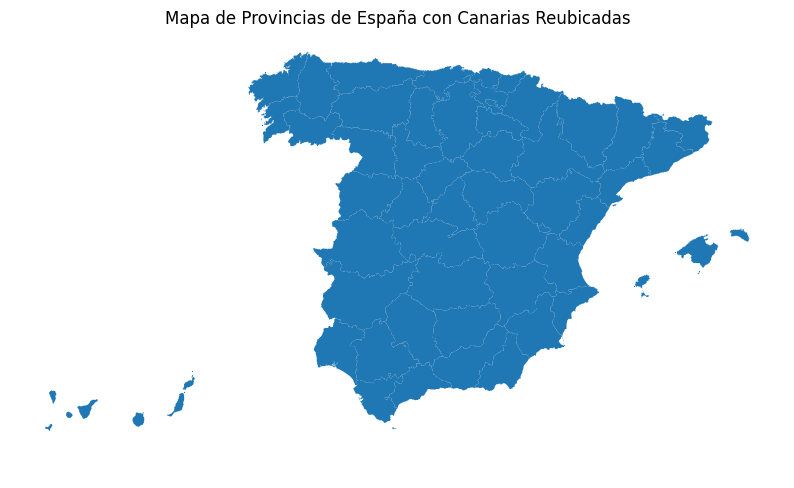

In [30]:
# Ruta al GeoJSON ajustado
geojson_path = "../mapas/esp_prov_canarias_ajustada.json"

# Cargar con GeoPandas
gdf = gpd.read_file(geojson_path)

# Crear figura y eje
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar provincias
gdf.plot(ax=ax)

# Título y limpieza de ejes
ax.set_title("Mapa de Provincias de España con Canarias Reubicadas")
ax.set_axis_off()

plt.show()

In [33]:
# Ruta de entrada y salida
INPUT_GEOJSON  = "../mapas/esp_prov_canarias_ajustada.json"
OUTPUT_GEOJSON = "../mapas/esp_prov_canarias_ajustada_linea.json"

with open(INPUT_GEOJSON, "r", encoding="utf-8") as f:
    geojson = json.load(f)

# Definir la "línea de conexión" en forma de "corchete"
line_feature = {
    "type": "Feature",
    "properties": {
        "stroke": "#0000ff",
        "stroke-width": 2,
        "stroke-opacity": 1.0
    },
    "geometry": {
        "type": "LineString",
        "coordinates": [
            [-11.0, 27.5],  # Punto a la izquierda de Canarias
            [-4.5, 27.5],   # Sobre las islas
            [-4.5, 36.5],   # Vertical hacia arriba
            [-6.0, 36.5]    # Hacia la península, conectando el bracket con Cádiz
        ]
    }
}

# Añadir el feature al GeoJSON
geojson["features"].append(line_feature)

# Guardar el GeoJSON modificado
with open(OUTPUT_GEOJSON, "w", encoding="utf-8") as f:
    json.dump(geojson, f, ensure_ascii=False, indent=2)

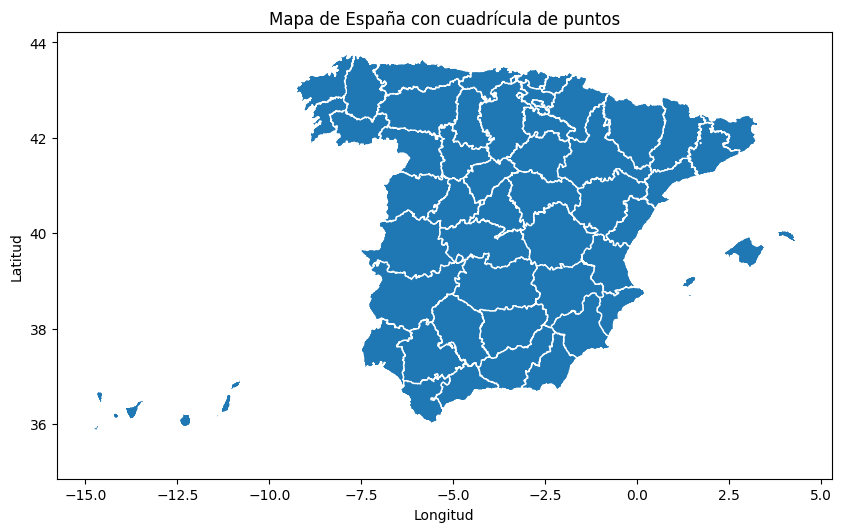

In [41]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Cargar GeoJSON de provincias
gdf = gpd.read_file(INPUT_GEOJSON)

# 3) Plot del mapa y la cuadrícula
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, edgecolor='white')

ax.set_title("Mapa de España con cuadrícula de puntos")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

plt.show()

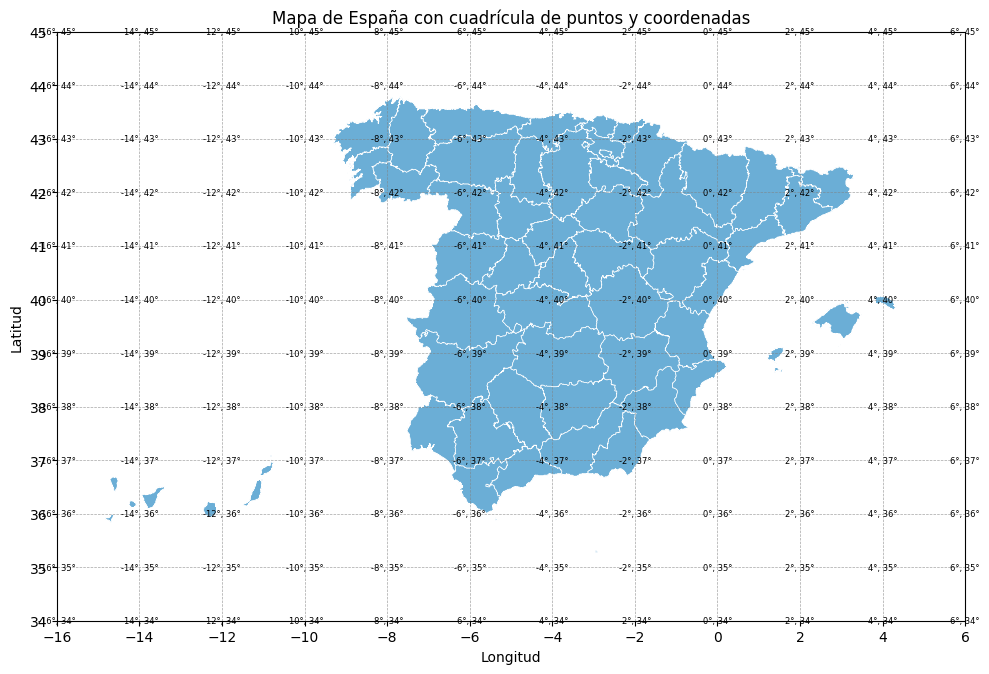

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Cargar GeoJSON
gdf = gpd.read_file(INPUT_GEOJSON)

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='#6baed6', edgecolor='white', linewidth=0.5)

# Obtener límites actuales
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

# Definir intervalo de cuadrícula
grid_lon = 2.0  # cada 2 grados de longitud
grid_lat = 1.0  # cada 1 grado de latitud
xticks = np.arange(np.floor(xmin), np.ceil(xmax) + grid_lon, grid_lon)
yticks = np.arange(np.floor(ymin), np.ceil(ymax) + grid_lat, grid_lat)

# Configurar ticks y cuadrícula
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.grid(True, linestyle='--', color='gray', linewidth=0.5, alpha=0.7)

# Etiquetar cada intersección con sus coordenadas
for x in xticks:
    for y in yticks:
        ax.text(x, y, f"{int(x)}°, {int(y)}°", fontsize=6, ha='center', va='center', color='black')

# Etiquetas y título
ax.set_title("Mapa de España con cuadrícula de puntos y coordenadas")
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

plt.tight_layout()
plt.show()